<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
!wget -O data https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

--2023-03-07 14:26:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [application/x-httpd-php]
Saving to: ‘data’

data                100%[===================>]   1.41M  --.-KB/s    in 0.07s   

2023-03-07 14:26:31 (20.7 MB/s) - ‘data’ saved [1477391/1477391]



In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
y.shape

(19020, 1)

In [ ]:
X.shape

(19020, 10)

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [5]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

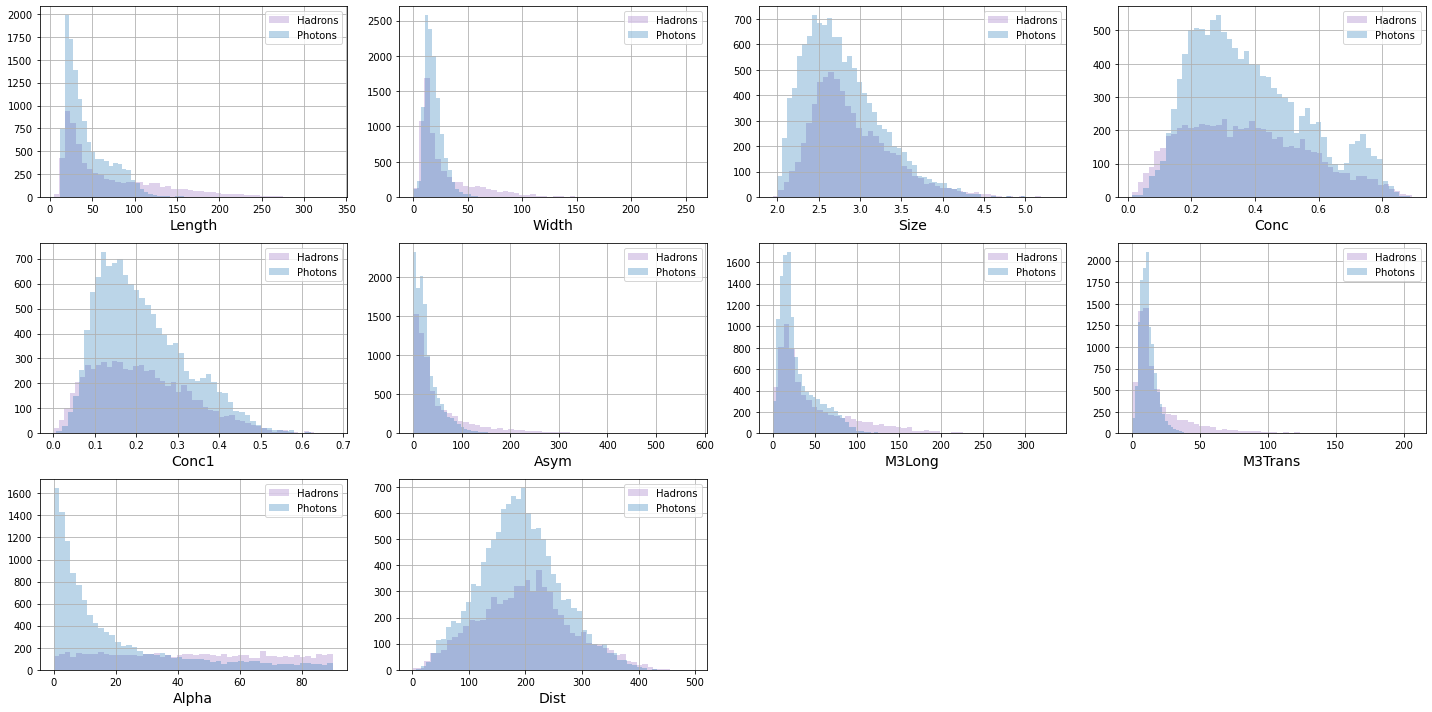

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [6]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

Text(0.5, 0, 'Train')

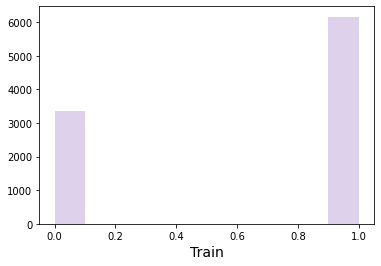

In [ ]:
plt.hist(y_train, alpha=0.3, color="C4")
plt.xlabel('Train', size=14)

Text(0.5, 0, 'Test')

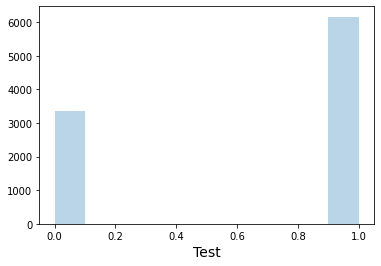

In [ ]:
plt.hist(y_test, alpha=0.3, color="C0")
plt.xlabel('Test', size=14)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [7]:
from sklearn.preprocessing import QuantileTransformer as QT

In [8]:
### YOUR CODE IS HERE ######
QT = QT(n_quantiles=15, random_state=1984, output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)
### THE END OF YOUR CODE ###

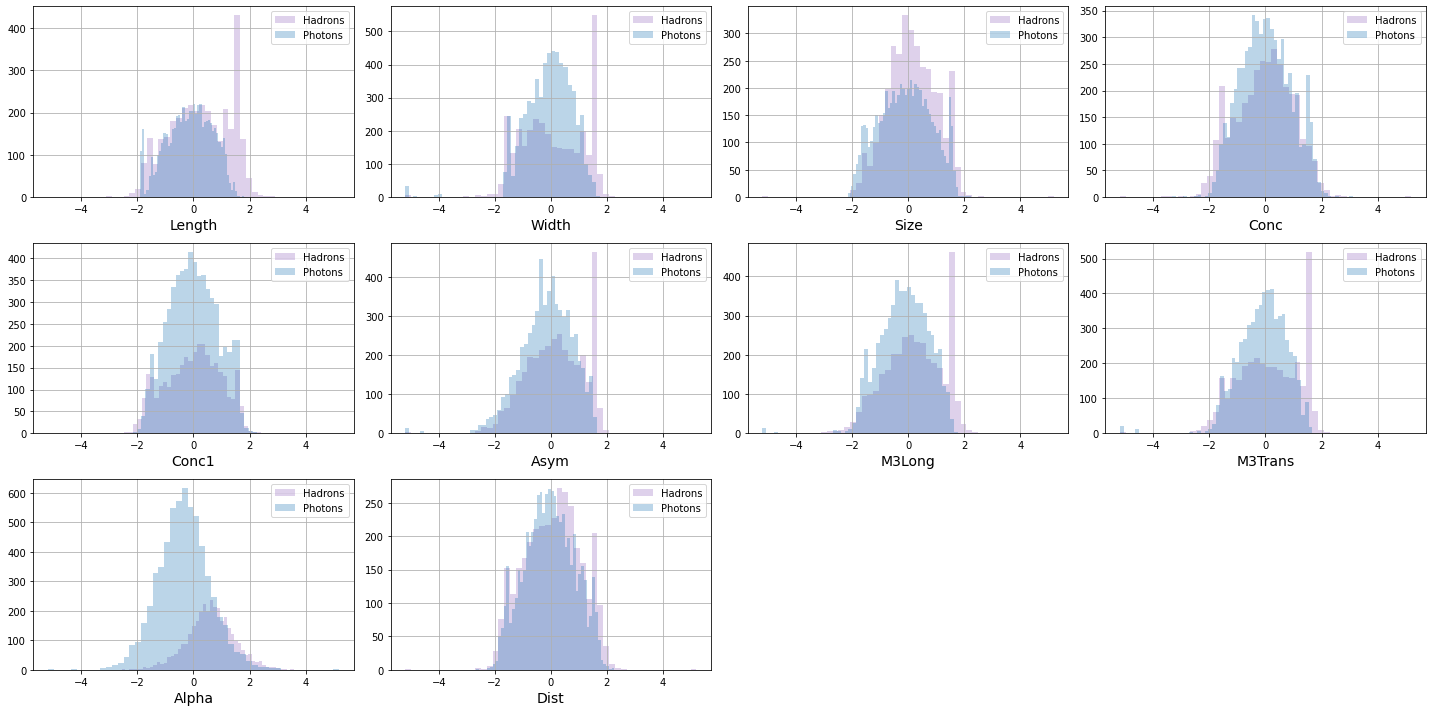

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

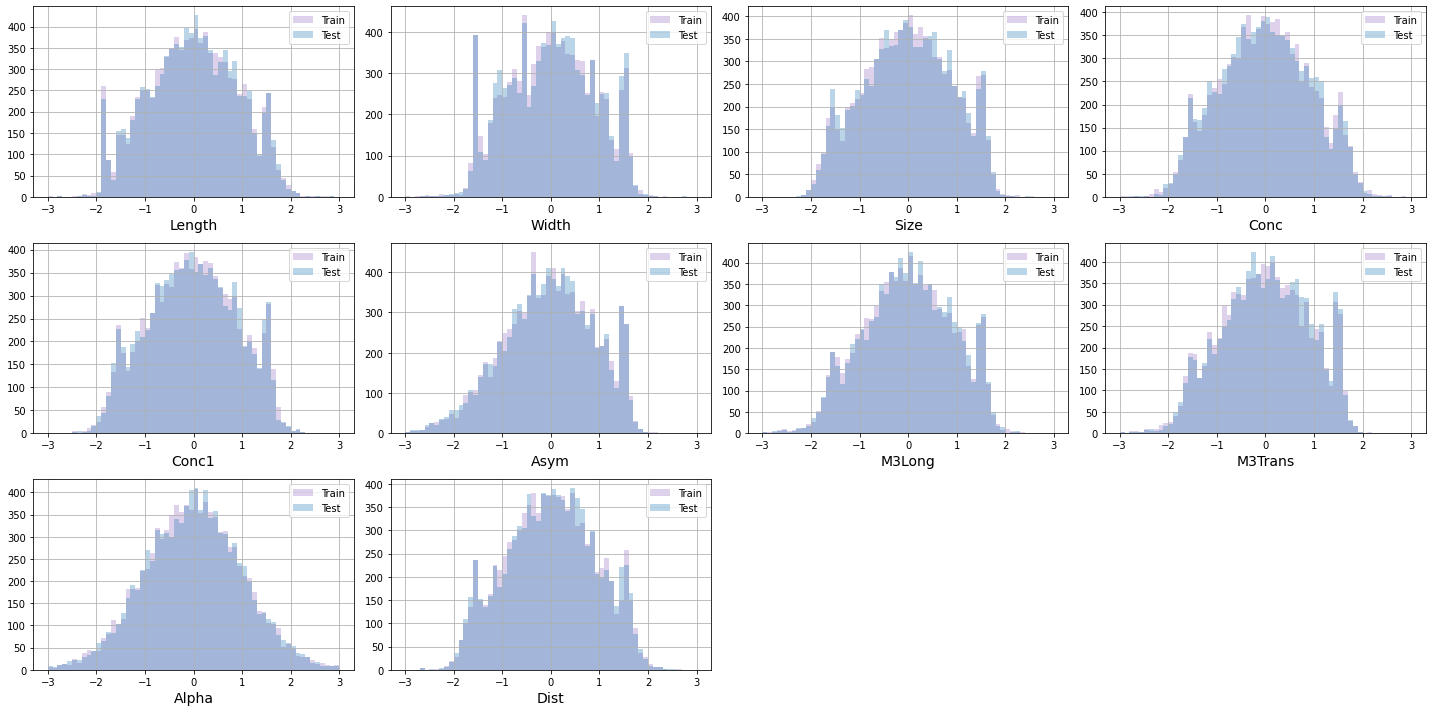

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [9]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100, device=DEVICE), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100, device=DEVICE),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs, device=DEVICE),
            )

    def forward(self, z, y):
        zy = torch.cat((torch.tensor(z), torch.tensor(y)), dim=1)
        return self.net(zy.to(torch.float32))

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [11]:
X_train.shape

(9510, 10)

In [10]:
def generate(generator, y, latent_dim):
    
    ### YOUR CODE IS HERE ######
    
    prior = torch.distributions.Normal(torch.zeros(10).to(DEVICE), torch.ones(1).to(DEVICE))
    z = prior.sample((y.shape[0],))    
    
    #gen = generator(latent_dim + y.shape[1], X.shape[1]) 
    X_fake = generator(torch.tensor(z), torch.tensor(y))
    
    ### THE END OF YOUR CODE ###
    
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######


        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

Кажется нужно конкатинировать Х и у, затем к фейковым данным в соответствие создать столбец 1, к реальным столбец 0. Затем нужно объединить для трейна и теста реальные и фейковые признаки (Х и у сконкатинированные + в качестве у регрессии использовать столбцы 1 и 0), именно столбцы 1 и 0 будут предсказываться.
 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

In [11]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    
    X_real = X_real.detach().cpu().numpy()
    X_fake = X_fake.detach().cpu().numpy()
    y_real = y_real.detach().cpu().numpy()
    y_fake = y_fake.detach().cpu().numpy()
    #print(X_real,'\n', y_real)

    X_real = np.concatenate((X_real, y_real), axis=1)
    X_fake = np.concatenate((X_fake, y_fake), axis=1)
    
    y_fake = np.ones((X_fake.shape[0], 1))
    y_real = np.zeros((X_real.shape[0], 1))

    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
                                                           X_real, y_real, test_size=0.25,
                                                           random_state=1984)
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(
                                                           X_fake, y_fake, test_size=0.25,
                                                           random_state=1984)
    
    X_train = np.concatenate((X_real_train, X_fake_train), axis=0)
    X_test = np.concatenate((X_real_test, X_fake_test), axis=0)

    y_train = np.concatenate((y_real_train, y_fake_train), axis=0)
    y_test = np.concatenate((y_real_test, y_fake_test), axis=0)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    lin_reg_preds = lin_reg.predict(X_test)
    lin_reg_preds[lin_reg_preds>=0.5] = 1
    lin_reg_preds[lin_reg_preds<0.5] = 0
    
    lin_reg_score = accuracy_score(y_test, lin_reg_preds)

    grad_boost = LGBMClassifier()
    grad_boost.fit(X_train, y_train)
    grad_boost_preds = grad_boost.predict(X_test)

    boosting_score = accuracy_score(y_test, grad_boost_preds) 

    ### THE END OF YOUR CODE ###
    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

❗❗❗**ВАЖНО! ВСЕ МОДЕЛИ БУДУТ ОБУЧАТЬСЯ НА CPU. ПРИ ПЕРЕХОДЕ НА GPU АЛГОРИТМЫ МОГУТ НАЧАТЬ РУГАТЬСЯ, ЧТО ДАННЫЕ ВЫНЕСЕНЫ НА РАЗНЫЕ УСТРОЙСТВА.**❗❗❗

In [12]:
from typing_extensions import Literal

In [15]:
def gan_loss(
    real_objects_scores: torch.Tensor, # D(x_i, y_i)
    generated_objects_scores: torch.Tensor, # D(G(z_i, y_i))
    by: Literal["generator", "discriminator"] = "generator",
) -> torch.Tensor:
    if by == "generator":
        return torch.log(1 - generated_objects_scores).mean()
    elif by == "discriminator":
        return (
            -torch.log(real_objects_scores).mean()
            - torch.log(1 - generated_objects_scores).mean()
        )

In [16]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.gen_opt = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.discr_opt = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        iter_i = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                real_objects = real_batch
                real_objects = real_objects.to(DEVICE)

                y = cond_batch
                y = y.to(DEVICE)

                prior = torch.distributions.Normal(torch.zeros(10).to(DEVICE), torch.ones(1).to(DEVICE))
                num_objects = real_objects.shape[0]
                z = prior.sample((num_objects,))
                gen_objects = generator(z, y)

                real_objects_scores, gen_objects_scores = torch.split(
                    discriminator(torch.cat([real_objects, gen_objects], dim=0),
                                  torch.cat([y, y], dim=0)), num_objects) 

                if (iter_i % (self.n_critic + 1) == 0):
                    # делаем шаг обучения генератора
                    self.gen_opt.zero_grad()
                    gen_loss = gan_loss(
                        real_objects_scores, gen_objects_scores, "generator"
                    )
                    gen_loss.backward()
                    self.gen_opt.step()
                    
                else:
                    # делаем шаг обучения дискриминатора
                    self.discr_opt.zero_grad()
                    discr_loss = gan_loss(
                        real_objects_scores, gen_objects_scores, "discriminator"
                    )
                    discr_loss.backward()
                    self.discr_opt.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    
                iter_i += 1

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            Z_noise = Z_noise.to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            X_real = X_real[0:1000]
            y_cond = y_cond[0:1000]
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
   
            #other_agent_score(X_real, y_cond, X_fake, y_cond)

            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [191]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=500,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

<ipython-input-186-d5b340245032>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
<ipython-input-186-d5b340245032>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
<ipython-input-157-4879b83f9fd1>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zy = torch.cat((torch.tensor(z), torch.tensor(y)), dim=1)


CPU times: user 5min 32s, sys: 611 ms, total: 5min 32s
Wall time: 5min 34s


<ipython-input-192-f61a32e7a212>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


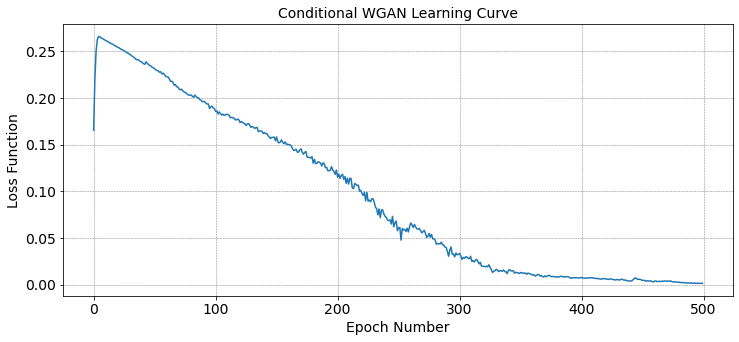

In [192]:
# WGAN learning curve
plt.figure(figsize=(12, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer as QT

In [18]:
X = data[names[:-1]].values
X = np.abs(X)
y = np.ones((len(labels), 1))
y[labels == "h"] = 0


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11)


QT = QT(n_quantiles=15, random_state=1984, output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

In [21]:
### YOUR CODE IS HERE ######

X_train= QT.inverse_transform(X_train)
X_test = QT.inverse_transform(X_test)

latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

### THE END OF YOUR CODE ###

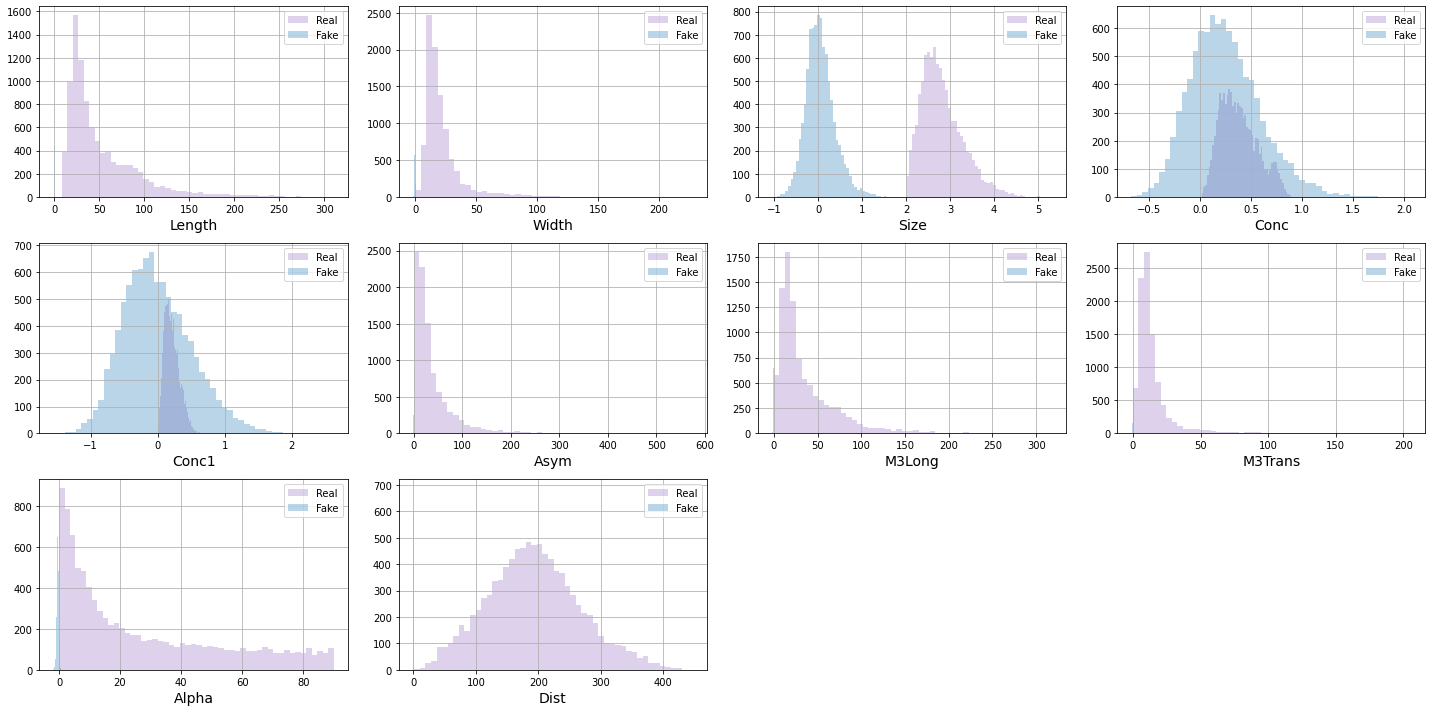

In [216]:
X_fake_train = generate(generator, y_train, 10)
X_fake_train = X_fake_train.detach().numpy()
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

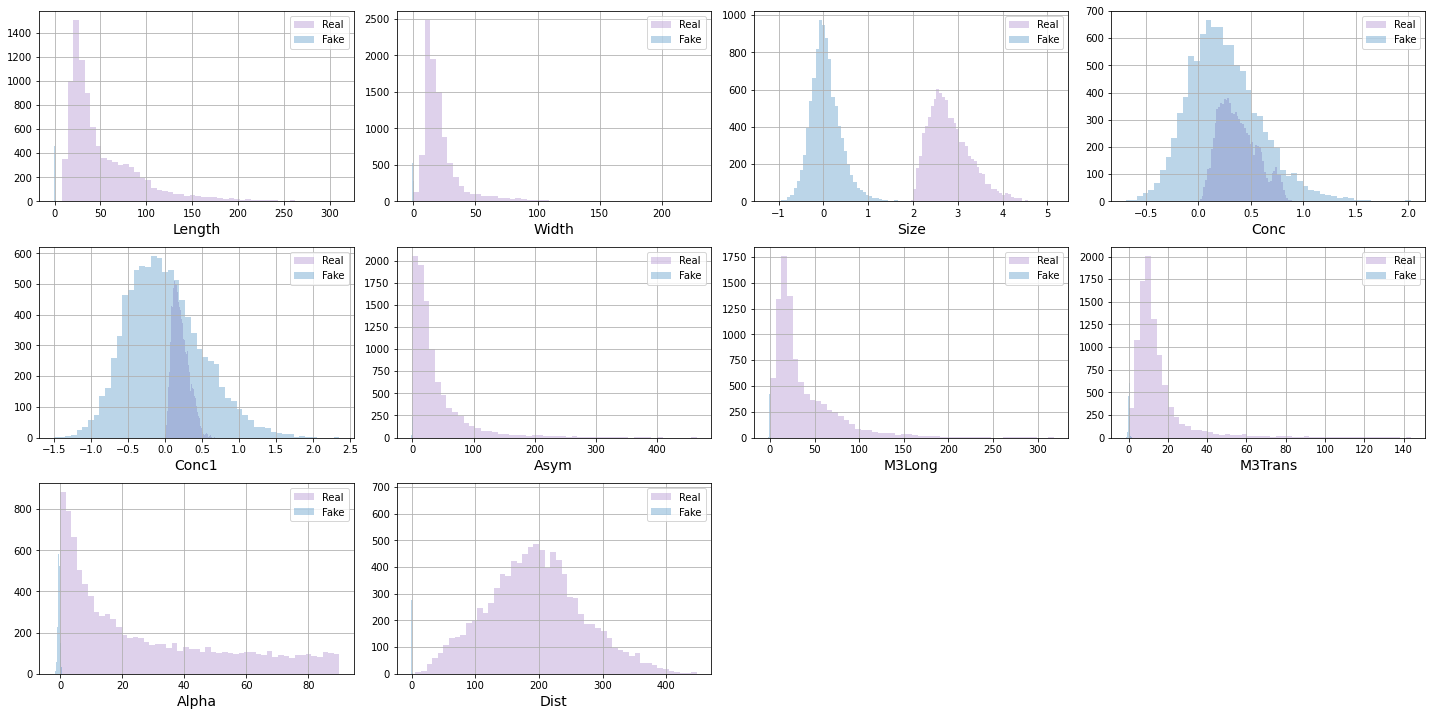

In [219]:
X_fake_test = generate(generator, y_test, latent_dim)
X_fake_test = X_fake_test.detach().numpy()
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [220]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [221]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [222]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  1.0


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


 

---


  Результат генерации обученной генеративной модели - неудовлетворительный, так как модель-классификатор градиентного бустинга смогла отличить фейковые данные от настоящих с 100% точностью на тесте, о чем говорит ROC AUC = 1. 

  Связано это с тем, что, как видно из графиков-распределений, некоторые признаки в фейковых данных распределены совершенно не как настоящие данные. Таким образом, градиентный бустинг просто учится по этим признакам отличать фейковые данные от настоящих и, разумеется, это отлично выходит.

  Площадь под ROC-кривой должна быть максимально близка к 0.5, так как это будет означать, что классифицирующая модель это все равно что подбрасывание монетки и никакой предсказательной ценности она не имеет.  


---



## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [13]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    x = x*(1-amount) + noise*amount 
    
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [14]:
!pip install diffusers
from diffusers import DDPMScheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.6 MB/s eta 0:00:00


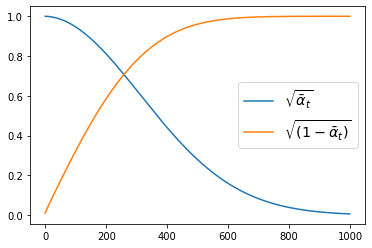

In [15]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [176]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.n_inputs = n_inputs 
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, self.n_outputs),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy.to(torch.float32))

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [177]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    ### YOUR CODE IS HERE ###

    noise = torch.randn(y.shape[0], latent_dim)
   
    for i, t in enumerate(scheduler.timesteps):
        with torch.no_grad():
            residual = model(noise, y)

        noise = scheduler.step(residual, t, noise).prev_sample
    
    ### THE END OF YOUR CODE ###
    return noise  

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [178]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        loss_fn = nn.MSELoss()

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                X = real_batch
                y = cond_batch
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                
                noise = torch.randn(X.shape[0], latent_dim)
                timesteps = torch.randint(0, 999, (X.shape[0],)).long().to(DEVICE)
                noisy_x = noise_scheduler.add_noise(X, noise, timesteps).to(DEVICE)

                pred = model(noisy_x, y)

                loss = loss_fn(pred, noise)
                loss_epoch += loss.detach().numpy()

                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                
                ### THE END OF YOUR CODE ###

            self.loss_history.append(loss_epoch)
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            X_real = X_real[0:1000]
            y_cond = y_cond[0:1000]
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.model(Z_noise, y_cond)
   
            #other_agent_score(X_real, y_cond, X_fake, y_cond)

            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

In [179]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=64,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

<ipython-input-178-c3ef1fdd48b7>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)


CPU times: user 1min 17s, sys: 146 ms, total: 1min 17s
Wall time: 1min 17s


<ipython-input-180-c0916e68e8fe>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


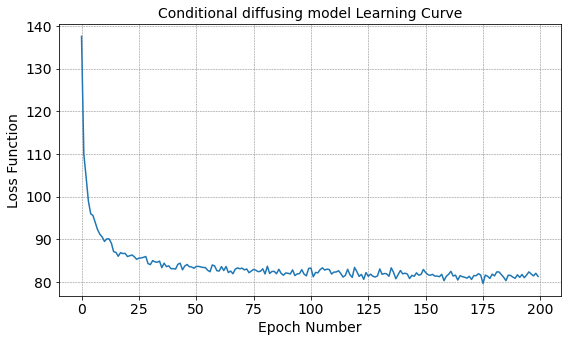

In [180]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer as QT

X = data[names[:-1]].values
X = np.abs(X)
y = np.ones((len(labels), 1))
y[labels == "h"] = 0


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11)


QT = QT(n_quantiles=15, random_state=1984, output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

In [164]:
X_train= QT.inverse_transform(X_train)
X_test = QT.inverse_transform(X_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

latent_dim = 10

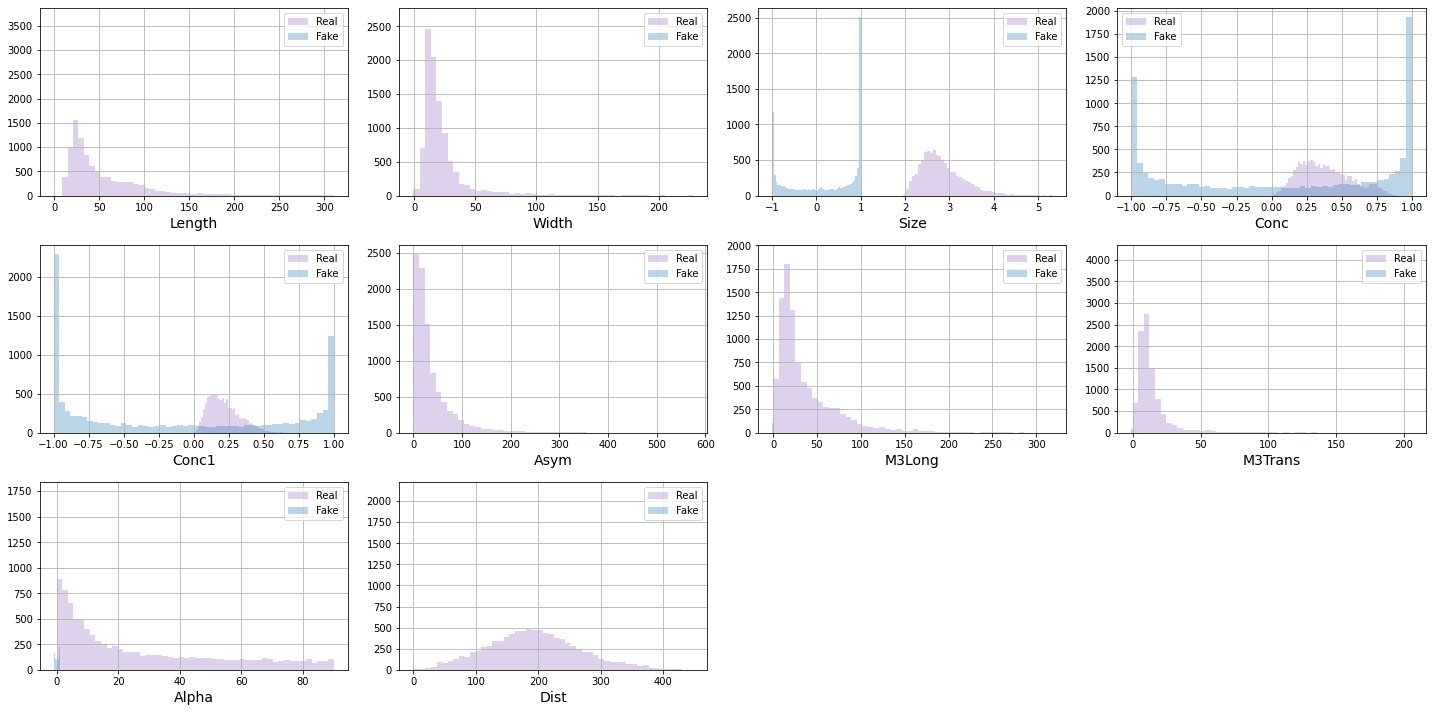

In [165]:
generator = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

X_fake_train = generate_with_diffusion(generator, y_train, latent_dim, noise_scheduler)
X_fake_train = X_fake_train.detach().numpy()
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

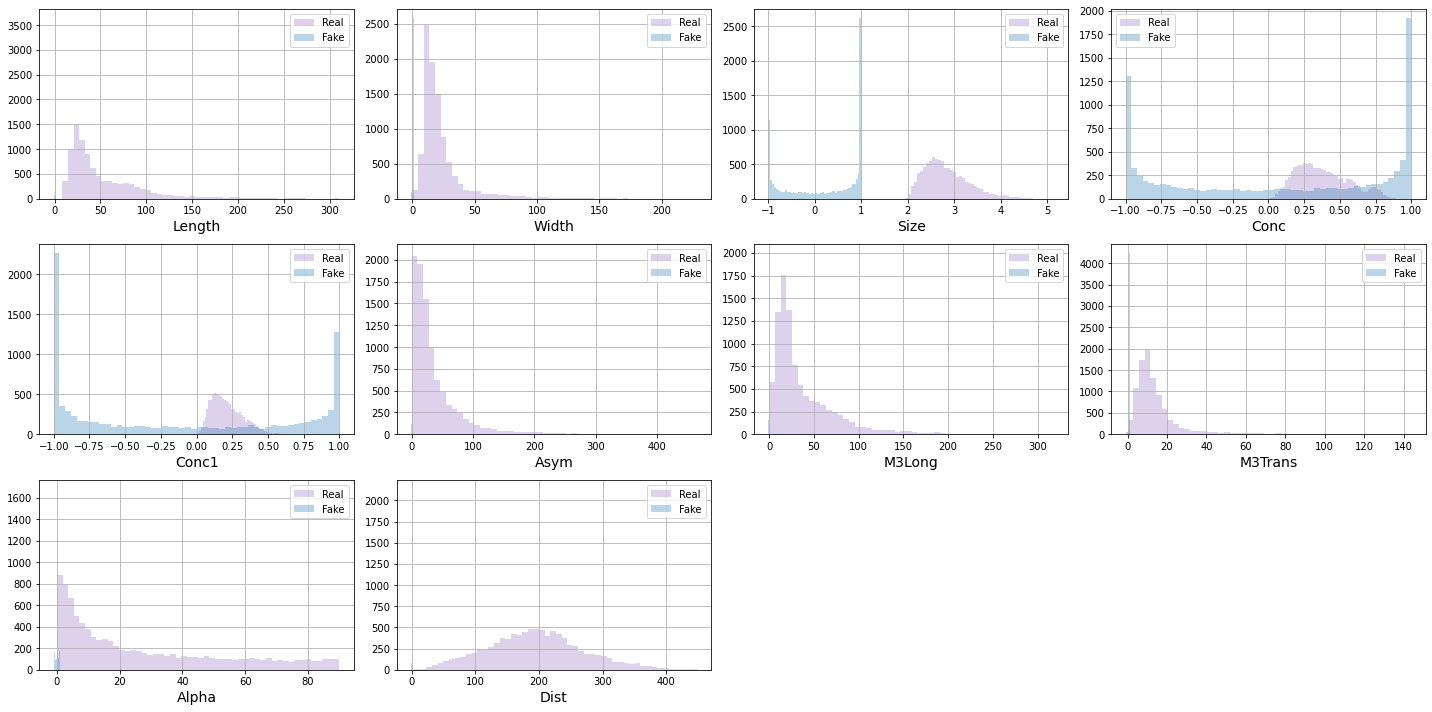

In [166]:
X_fake_test = generate_with_diffusion(generator, y_test, latent_dim, noise_scheduler)
X_fake_test = X_fake_test.detach().numpy()
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [167]:
# собираем реальную и фейковую матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [168]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [174]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  1.0


## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!